# Part 1

**What did we learn last week?**: We got a first look at PyTorch and trained a deep learning model with automatic differentiation.

**What you will learn today**: We will take a closer look at Convolutional Neural Networks and understand why they are ubiquitously used. Then, we will look at the *correct* way of evaluating performance. Finally, we will explore some important hyperparameters/design decision for
boosting performance.

## Convolutional Neural Networks

Great sources:
- https://poloclub.github.io/cnn-explainer/
- https://setosa.io/ev/image-kernels/

![](https://poloclub.github.io/cnn-explainer/assets/figures/convlayer_detailedview_demo.gif)

**Why convolutions and not fully-connected layers?** In the previous lab, we used a MultiLayer Perceptron (MLP) to perform classification on the MNIST dataset of handwritten digits. However, MLPs expect a vector as an input and, hence, our first step was to *flatten* the image; from an input of shape $(1, 28, 28)$ we got a vector of $1\times28\times28=784$ elements. Then, each layer of the MLP is fully connected, meaning that all $784$ elements are fed into each neuron of the next layer.

Does this sound reasonable?

No! First, by flattening we implicitly lose *local* information. Assume you look at pixel in location $(5,5)$, then the neighboring pixels $(4,5),(6,5), (5,4), (5,6),\dots$ are important and must be "somewhat similar". Second, by using all elements of the previous layer. the top left and bottom right pixels are used in the same computation.

Convolutional Neural Networks address these (and more) concerns and are suitable for the image domain. But, what are convolutions? We start with a small matrix of weights, e.g. $3\times3$, which is called a kernel. The kernel is then slided over the 2d input and we perform elementwise multiplication with the values the kernel is currently on. The summation of the $3\times3=9$ elements is the output for the pixel. Hence, the kernel performs a "local" computation. *Back in the day*, kernels were hand-designed to perform a specific operation. For example, the Sobel operator is used for edge-detection:

$$
\mathbf{G}_x=\left[\begin{array}{ccc}
+1 & 0 & -1 \\
+2 & 0 & -2 \\
+1 & 0 & -1
\end{array}\right] * \mathbf{A} \quad \text { and } \quad \mathbf{G}_y=\left[\begin{array}{ccc}
+1 & +2 & +1 \\
0 & 0 & 0 \\
-1 & -2 & -1
\end{array}\right] * \mathbf{A}
$$

$$
\mathbf{G}=\sqrt{\mathbf{G}_x^2+\mathbf{G}_y^2}
$$

For example:

![](https://miro.medium.com/max/640/1*m9XHMKQPY6mKYsaykuVAsw.webp)

Creating filters for every different scenario requires domain knowledge and is cumbersome. (Convolutional) Neural Networks learn the values of these filters in an "end-to-end" manner!

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
# import our "local" library of functions
from training_utils import train_epoch, fit, predict, visualize_images, plot_loss

# also import everything else that we need
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [ ]:
# define the hyperparameters
BATCH_SIZE = 1024
TEST_BATCH_SIZE = 1024
LEARNING_RATE = 0.01

# find out which device is available
DEVICE = None
if torch.cuda.is_available():
    # Requires NVIDIA GPU with CUDA installed
    DEVICE = torch.device("cuda")
elif torch.mps.is_available():
    # Requires Apple computer with M1 or later chip
    DEVICE = torch.device("mps")
else:
    # Not recommended, because it's slow. Move to Google Colab!
    DEVICE = torch.device("cpu")

print(DEVICE)

cuda


In [ ]:
transform = torchvision.transforms.ToTensor()

# load the train dataset
train_dataset = torchvision.datasets.MNIST(
    root='./data/',
    train=True,
    download=True,
    transform=transform)

# load the test dataset
test_dataset = torchvision.datasets.MNIST(
    root='./data/',
    train=False,
    download=True,
    transform=transform)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2)


test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

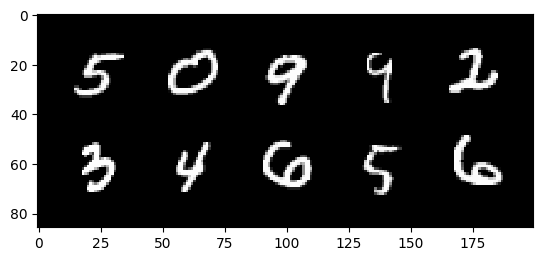

In [ ]:
visualize_images(train_dataloader)

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # We use a Sequential, i.e. the inputs passes through each of
        # the modules below, one-by-one
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # fully connected layer, output 10 classes
        self.out = nn.Linear(1568, 10)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1) #reshape the tensor
        x = self.out(x)
        return x


In [ ]:
# initialize model
cnn = CNN().to(DEVICE)

# define the optimizer
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.1)

# train the CNN
losses = fit(
    model=cnn,
    train_dataloader=train_dataloader,
    optimizer=optimizer,
    epochs=10,
    device=DEVICE
)

predict(model=cnn, test_dataloader=test_dataloader, device=DEVICE)

Epoch 0: Loss=1.332640411490101
Epoch 1: Loss=0.3645934502957231
Epoch 2: Loss=0.23499923565630185
Epoch 3: Loss=0.18626431060039392
Epoch 4: Loss=0.15853252514439115
Epoch 5: Loss=0.13992503133870787
Epoch 6: Loss=0.12379073237968703
Epoch 7: Loss=0.1147763071171308
Epoch 8: Loss=0.10674446088782812
Epoch 9: Loss=0.09777303393614495
Test set: Avg. loss: 0.0853, Accuracy: 9739/10000 (97%)


(0.0853499568939209, tensor(97.3900, device='cuda:0'))

## CIFAR10

In [ ]:
transform = torchvision.transforms.ToTensor()

# load the train dataset
train_dataset = torchvision.datasets.CIFAR10(
    root='./data/',
    train=True,
    download=True,
    transform=transform)

# load the test dataset
test_dataset = torchvision.datasets.CIFAR10(
    root='./data/',
    train=False,
    download=True,
    transform=transform)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2)


test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


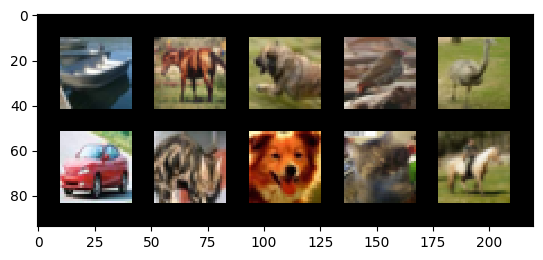

In [ ]:
visualize_images(train_dataloader)

In [ ]:
class CifarCNN(nn.Module):
    def __init__(self):
        super().__init__()

        # We use a Sequential, i.e. the inputs passes through each of
        # the modules below, one-by-one
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=3, #COLORED IMAGES!
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # fully connected layer, output 10 classes
        self.out = nn.Linear(2048, 10) #Now is 32x32 images!

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.out(x)
        return x

cnn_cifar = CifarCNN().to(DEVICE)

# define the optimizer
optimizer = torch.optim.SGD(cnn_cifar.parameters(), lr=0.1)


# train the CNN
losses = fit(
    model=cnn_cifar,
    train_dataloader=train_dataloader,
    optimizer=optimizer,
    epochs=10,
    device=DEVICE
)

predict(model=cnn_cifar, test_dataloader=test_dataloader, device=DEVICE)

Epoch 0: Loss=2.2660717818201803
Epoch 1: Loss=2.2376664949923146
Epoch 2: Loss=2.1274009918679995
Epoch 3: Loss=1.9877657111810179
Epoch 4: Loss=1.8804077493901155
Epoch 5: Loss=1.8035033308729833
Epoch 6: Loss=1.6969936672522097
Epoch 7: Loss=1.6376106276804088
Epoch 8: Loss=1.59001759850249
Epoch 9: Loss=1.5490645413496056
Test set: Avg. loss: 1.5063, Accuracy: 4556/10000 (46%)


(1.5062629150390625, tensor(45.5600, device='cuda:0'))

**Takeaways**: CIfar10 is a more complex dataset than MNIST; the images are larger and RGB, the model is larger and a simple training scheme returns very bad results! How can we change this?

## Validation set

Before looking into tips and tricks for boosting the performance of a model, we need to establish a proper evaluation protocol. This is where the validation set comes in.

In the real world, we do not have access to the test set, e.g., customer churning or self-driving cars. But, still, we need to evaluate the performance of our models on *unseen data*. The most common way is to split the training set into training+validation.

In [ ]:
# load the train dataset
train_dataset = torchvision.datasets.MNIST(
    root='./data/',
    train=True,
    download=True,
    transform=transform)

# load the test dataset
test_dataset = torchvision.datasets.MNIST(
    root='./data/',
    train=False,
    download=True,
    transform=transform)

print(train_dataset)

# Split the dataset into 50k-10k samples for training-validation.
from torch.utils.data import random_split
train_dataset,  valid_dataset = random_split(
    train_dataset,
    lengths=[50000, 10000],
    generator=torch.Generator().manual_seed(42) #use a generator to insure reproducibilty
)

# what is the type of the "new" training dataset?
print(train_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: ToTensor()


In [ ]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2)

valid_dataloader = DataLoader(
    dataset=valid_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=2)

**Question** Modify the fit function to also use a validation set.

In [ ]:
def fit_val(model, train_dataloader, optimizer, epochs, device, valid_dataloader):
    train_losses = []
    validation_losses = []
    for epoch in range(epochs):
        train_loss = train_epoch(
            model=model,
            train_dataloader=train_dataloader,
            optimizer=optimizer,
            device=device
        )
        train_losses.append(train_loss)
        validation_loss, _ = predict(model, valid_dataloader, device, verbose=False)
        validation_losses.append(validation_loss)

        print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Validation Loss={validation_loss:.4f}")

    return train_losses, validation_losses

In [ ]:
# train the model
cnn = CNN().to(DEVICE)
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.1)
train_losses, validation_losses = fit_val(
    model=cnn,
    train_dataloader=train_dataloader,
    optimizer=optimizer,
    epochs=10,
    device=DEVICE,
    valid_dataloader=valid_dataloader
)
predict(model=cnn, test_dataloader=test_dataloader, device=DEVICE);

Epoch 0: Train Loss=1.5447, Validation Loss=0.6663
Epoch 1: Train Loss=0.5137, Validation Loss=0.3451
Epoch 2: Train Loss=0.3083, Validation Loss=0.2607
Epoch 3: Train Loss=0.2299, Validation Loss=0.2246
Epoch 4: Train Loss=0.1947, Validation Loss=0.1858
Epoch 5: Train Loss=0.1671, Validation Loss=0.1603
Epoch 6: Train Loss=0.1469, Validation Loss=0.1473
Epoch 7: Train Loss=0.1329, Validation Loss=0.1318
Epoch 8: Train Loss=0.1217, Validation Loss=0.1225
Epoch 9: Train Loss=0.1126, Validation Loss=0.1156
Test set: Avg. loss: 0.1002, Accuracy: 9697/10000 (97%)


## Importance of optimizer and learning rate

So far in this lab, we have used the same learning rate and optimizer (vanilla SGD). However, the choice of optimizer and the corresponding hyperparameters play a crucial role in the end performance.

### Learning rate
**Question** Explore the exact same experiment as before BUT change the learning rate to $0.001$. How does this change affect performance?

In [ ]:
cnn = CNN().to(DEVICE)
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.001)
train_losses2, validation_losses2 = fit_val(
    model=cnn,
    train_dataloader=train_dataloader,
    optimizer=optimizer,
    epochs=10,
    device=DEVICE,
    valid_dataloader=valid_dataloader
)
predict(model=cnn, test_dataloader=test_dataloader, device=DEVICE);

Epoch 0: Train Loss=2.3003, Validation Loss=2.2972
Epoch 1: Train Loss=2.2951, Validation Loss=2.2920
Epoch 2: Train Loss=2.2899, Validation Loss=2.2867
Epoch 3: Train Loss=2.2846, Validation Loss=2.2814
Epoch 4: Train Loss=2.2792, Validation Loss=2.2759
Epoch 5: Train Loss=2.2736, Validation Loss=2.2703
Epoch 6: Train Loss=2.2679, Validation Loss=2.2644
Epoch 7: Train Loss=2.2619, Validation Loss=2.2583
Epoch 8: Train Loss=2.2556, Validation Loss=2.2519
Epoch 9: Train Loss=2.2490, Validation Loss=2.2451
Test set: Avg. loss: 2.2442, Accuracy: 3137/10000 (31%)


**Question** Now try with a higher learning rate ($\eta\geq0.5$), describe (qualitative) what happens.

In [ ]:
cnn = CNN().to(DEVICE)
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.6)
train_losses3, validation_losses3 = fit_val(
    model=cnn,
    train_dataloader=train_dataloader,
    optimizer=optimizer,
    epochs=10,
    device=DEVICE,
    valid_dataloader=valid_dataloader
)
predict(model=cnn, test_dataloader=test_dataloader, device=DEVICE);

Epoch 0: Train Loss=2.3723, Validation Loss=2.2504
Epoch 1: Train Loss=2.2364, Validation Loss=1.7680
Epoch 2: Train Loss=1.2273, Validation Loss=0.6531
Epoch 3: Train Loss=0.6623, Validation Loss=0.5795
Epoch 4: Train Loss=0.5291, Validation Loss=0.4262
Epoch 5: Train Loss=0.4097, Validation Loss=0.4166
Epoch 6: Train Loss=0.3095, Validation Loss=0.3035
Epoch 7: Train Loss=0.2648, Validation Loss=0.2312
Epoch 8: Train Loss=0.2273, Validation Loss=0.2963
Epoch 9: Train Loss=0.1981, Validation Loss=0.1994
Test set: Avg. loss: 0.1835, Accuracy: 9425/10000 (94%)


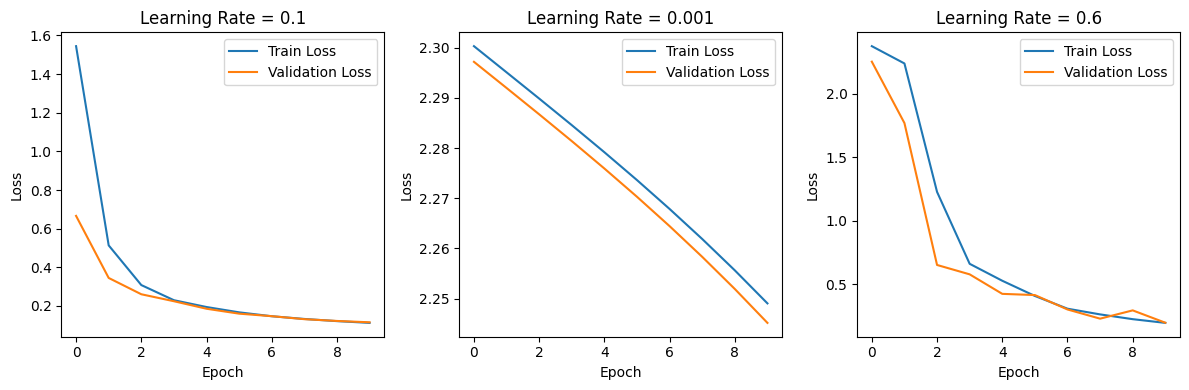

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(validation_losses, label="Validation Loss")
plt.title("Learning Rate = 0.1")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(train_losses2, label="Train Loss")
plt.plot(validation_losses2, label="Validation Loss")
plt.title("Learning Rate = 0.001")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1, 3, 3)
plt.plot(train_losses3, label="Train Loss")
plt.plot(validation_losses3, label="Validation Loss")
plt.title("Learning Rate = 0.6")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

### Optimizer

In this lab we have used (mini-batch) Stochastic Gradient Descent or simply SGD. For simplicity we consider the case for only one sample. The update rule is the following:

$$
\mathbf{w}^{(\tau+1)} \gets \mathbf{w}^{(\tau)} - \eta\nabla L\left(\mathbf{x}, y;\mathbf{w}^{(\tau)}\right)
$$

How can we improve our algorithm and encourage faster convergence? Momentum can actually help. The idea is simple: we will use the update made on the previous step and incorporate it to our current update, giving momentum to our algorithm. The actual update rule is the following:

$$
\begin{align}
\mathbf{v}^{(\tau+1)} &\gets \gamma\mathbf{v}^{(\tau)} + \nabla L\left(\mathbf{x}, y;\mathbf{w}^{(\tau)}\right)
\\
\mathbf{w}^{(\tau+1)} &\gets \mathbf{w}^{(\tau)} - \eta \mathbf{v}^{(\tau)}
\end{align}
$$

Apart from making convergence faster, momentum has other benefits:
* dampens oscillations
* helps us navigate ravines around local optima [1]

If you are more interested in the various optimizers take a look at reference [1].

----
[1] Ruder, S., 2016. An overview of gradient descent optimization algorithms. arXiv preprint arXiv:1609.04747.



**Question** Implement momentum and compute the learning curve. How does this change affect performance?

In [ ]:
     # use optimizer with momentum
cnn = CNN().to(DEVICE)
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.1, momentum=0.1)
train_losses_mom, validation_losses_mom = fit_val(
    model=cnn,
    train_dataloader=train_dataloader,
    optimizer=optimizer,
    epochs=10,
    device=DEVICE,
    valid_dataloader=valid_dataloader
)
predict(model=cnn, test_dataloader=test_dataloader, device=DEVICE);

Epoch 0: Train Loss=1.3922, Validation Loss=0.6130
Epoch 1: Train Loss=0.4714, Validation Loss=0.3789
Epoch 2: Train Loss=0.2801, Validation Loss=0.2450
Epoch 3: Train Loss=0.2187, Validation Loss=0.2106
Epoch 4: Train Loss=0.1788, Validation Loss=0.1730
Epoch 5: Train Loss=0.1558, Validation Loss=0.1521
Epoch 6: Train Loss=0.1358, Validation Loss=0.1357
Epoch 7: Train Loss=0.1223, Validation Loss=0.1241
Epoch 8: Train Loss=0.1127, Validation Loss=0.1162
Epoch 9: Train Loss=0.1042, Validation Loss=0.1089
Test set: Avg. loss: 0.0908, Accuracy: 9736/10000 (97%)


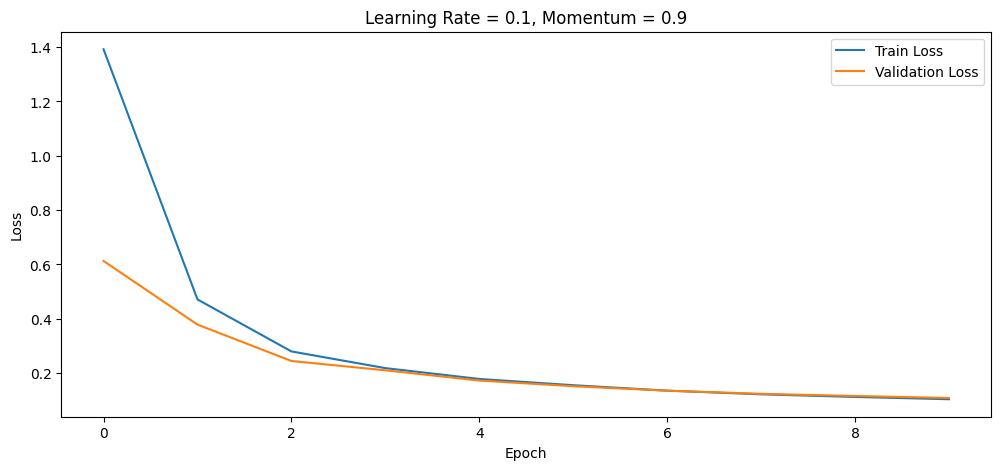

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(train_losses_mom, label="Train Loss")
plt.plot(validation_losses_mom, label="Validation Loss")
plt.title("Learning Rate = 0.1, Momentum = 0.9")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Hyperparameters: Learning rate and batch size

While intution can help us select the settings of an experiment, the choice becomes complicated when more and more hyperparameters need to be taken account. Just to name a few, we might want to select learning rate, momentum or optimizer, batch size, number of layers, width of layers etc

Hence, we need a systematic way to approach this problem. The most simple way is to perfrom a grid search; define a list of choices for each hyperparameter and search over all combinations.


**Question** Perform a grid search over the learning rate and batch size. What is the best combination?

# Part 2

On the previous part we implemented CNNs using the `PyTorch` library. Our experiments showed that for image classification a CNN architecture yields good results on MNIST and, depending on the complexity of the network you created, "good" results on CIFAR10. However, dealing with MNIST someone might have gotten the wrong impression: "everythings work out-of-the-box or like magic in Deep Learning". Reality is not so rosy and we must go to great lengths do replicate our success on MNIST for other datasets.

In this part, we will explore common pitfalls as well as common tips and tricks to resolve them. These simple methods will provide superior performance and are very easy to incorporate in our pipeline.

Specifically, we will talk about:
- Batch Normalization
- Learning rate scheduler
- Residual Connections

So... let's get started!


In [ ]:
# first we load all the necessary libraries

import torchvision.transforms as transforms
import torchvision as torchvision
import torch.nn.functional as F

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

# load the train dataset
train_dataset = torchvision.datasets.CIFAR10(
    root='./data/',
    train=True,
    download=True,
    transform=transform)

# load the test dataset
test_dataset = torchvision.datasets.CIFAR10(
    root='./data/',
    train=False,
    download=True,
    transform=transform)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2)


## Batch normalization

We want to learn fast and converge at the same time. If we use a small learning rate, we will converge but it will be too slow. On the other hand, if we use large learning rate, our training will become inconsistent and we will bounce all over the place and never converge. Additionaly, higher learning rates  cause exploding or vanishing gradients i.e. the phenomenon where the multiplication of gradients via the chain rule induces a compound effect on the lower layers, preventing them from learning.

Can we have the best of both worlds? Enter **Batch Normalization**.

1. What does BatchNorm aims to solve? We want to
    * avoid unstable gradients,
    * allow faster learning rates leading to faster convergence,
    * reduce the effect of initialization.

2. Why does BatchNorm actually do?
    * Suppose we are given values of $x=1$

We want to learn fast and converge at the same time. If we use a small learning rate, we will converge but it will be too slow. On the other hand, if we use large learning rate, our training will become inconsistent and we will bounce all over the place and never converge. Additionaly, higher learning rates  cause exploding or vanishing gradients i.e. the phenomenon where the multiplication of gradients via the chain rule induces a compound effect on the lower layers, preventing them from learning.

Can we have the best of both worlds? Enter **Batch Normalization**.

1. What does BatchNorm aims to solve? We want to
    * avoid unstable gradients,
    * allow faster learning rates leading to faster convergence,
    * reduce the effect of initialization.

2. Why does BatchNorm actually do?

Suppose we are given values of $x$ over a mini-batch $B=\{x_i\}_{i=1}^m$. Our goal is to learn some parameters $\gamma$ and $\beta$ that perform the proper scaling.

- First, we compute the mini-batch mean
    $$
    \mu_{B}=\frac{1}{m}\sum_{i=1}^mx_i
    $$
and mini-batch variance
    $$
    \sigma^2_{B}=\frac{1}{m}\sum_{i=1}^m (x_i-\mu_{B})^2
    $$
- we use these quantities to normalize our input
    $$
    x_i\leftarrow\frac{x_i-\mu_{B}}{\sqrt{\sigma^2_{B}+\epsilon}}
    $$
- We scale, shift and return the output
    $$
    y_i=\gamma x_i+\beta\equiv \text{BN}_{\gamma, \beta}(x_i)
    $$
Essentially, for each mini-batch we normalize the inputs by subtracting their mean and dividing by their standard deviation (estimated based on the statistics of the current mini-batch)  


3. Why does BatchNorm work?

    * BatchNorm is widely used (e.g. the original paper [1] has over 50000 citations). However, the reasons of its success are not perfectly clear.
    * The original authors claim that BatchNorm helps alleviate *Internal Covariate shift*, i.e. the phenomenon of shifting input distributions. Specifically, the input to each layer can be seen as a data distribution that the layer is trying to “learn”. The model, though, does not see the whole dataset but simply mini-batches. If this distribution stays consistent across batches, the layer can "learn effectively".  But, does this happen in practice?
    * the reality is that different mini-batches have different statistics, e.g. mean, variance etc, making the input distribution to the layers jump around. In other words, the input distribuion shifts for every mini-batch. We are trying to learn a "moving target". What if we stabilize it?
    * Batch normalization keeps the input normalized (duh!), preventing them from becoming too large or small and keeping the distribution consistent.
    
    * It also directly placates the exploding/vanishing gradient problem and  allows higher learning rates.

    * However, other explanations have been proposed. [2] claims that BatchNorm "makes the optimization landscape significantly smoother. This smoothness induces a more predictive and stable behavior of the gradients, allowing for faster training".


---
[1] S. Ioffe and C. Szegedy, “Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift,” in Proceedings of the 32nd International Conference on Machine Learning, Jun. 2015, pp. 448–456. Accessed: Oct. 25, 2021. [Online]. Available: https://proceedings.mlr.press/v37/ioffe15.html

[2] S. Santurkar, D. Tsipras, A. Ilyas, and A. Madry, “How Does Batch Normalization Help Optimization?,” in Advances in Neural Information Processing Systems, 2018, vol. 31. Accessed: Oct. 25, 2021. [Online]. Available: https://papers.nips.cc/paper/2018/hash/905056c1ac1dad141560467e0a99e1cf-Abstract.html



**Question** Redo the previous cnn architecture with batch normalization.
Where does the batch normalization go?

In [ ]:
class BN_CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
        )

        self.out = nn.Linear(2048, 10)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.out(x)
        return x

bn_cnn = BN_CNN().to(DEVICE)
optimizer = torch.optim.SGD(bn_cnn.parameters(), lr=0.01, momentum=0.9)

fit_data = fit(
    model=bn_cnn,
    train_dataloader=train_dataloader,
    optimizer=optimizer,
    epochs=10,
    device=DEVICE
)

predict(model=bn_cnn, test_dataloader=test_dataloader, device=DEVICE)


Epoch 0: Loss=1.5294754821427015
Epoch 1: Loss=1.1464172917969373
Epoch 2: Loss=1.02608357157026
Epoch 3: Loss=0.9670600136932062
Epoch 4: Loss=0.9146123017583575
Epoch 5: Loss=0.8789603077635473
Epoch 6: Loss=0.853247661979831
Epoch 7: Loss=0.8222379477656617
Epoch 8: Loss=0.797682595496275
Epoch 9: Loss=0.779824783607405
Test set: Avg. loss: 1.2930, Accuracy: 5886/10000 (59%)


(1.2930046875, tensor(58.8600, device='cuda:0'))

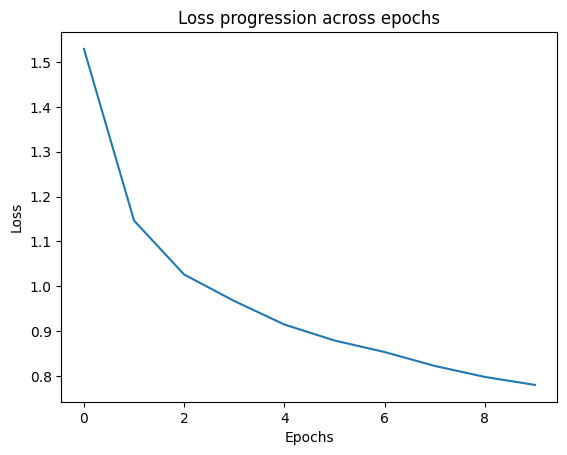

In [ ]:
plot_loss(fit_data)

**Question** One of the benefits of Batch Norm is that it allows us to use higher learning rates. Adapt the code above to do so. Does the model learn faster?


Epoch 0: Loss=3.5382217022837423
Epoch 1: Loss=1.619631010658887
Epoch 2: Loss=1.4391763453580895
Epoch 3: Loss=1.3609755209514074
Epoch 4: Loss=1.3130338994824156
Epoch 5: Loss=1.268047337629357
Epoch 6: Loss=1.2354895946930866
Epoch 7: Loss=1.2156733517744103
Epoch 8: Loss=1.1880278344057045
Epoch 9: Loss=1.1725074296094933
Test set: Avg. loss: 1.2595, Accuracy: 5466/10000 (55%)


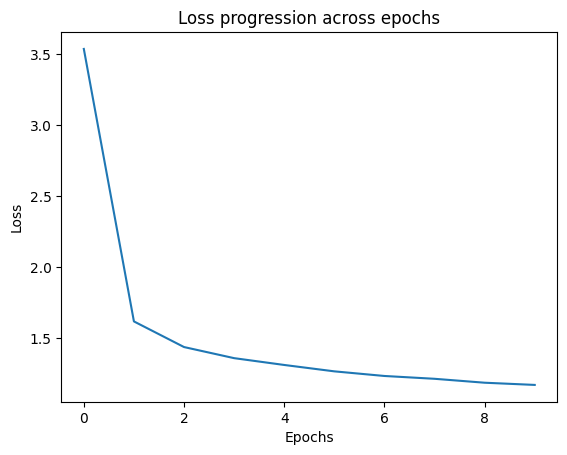

In [ ]:
bn_cnn = BN_CNN().to(DEVICE)
optimizer = torch.optim.SGD(bn_cnn.parameters(), lr=0.1, momentum=0.9)

fit_data = fit(
    model=bn_cnn,
    train_dataloader=train_dataloader,
    optimizer=optimizer,
    epochs=10,
    device=DEVICE
)

predict(model=bn_cnn, test_dataloader=test_dataloader, device=DEVICE)
plot_loss(fit_data)

## Learning rate scheduler

We have just seen that batch normalization allows, in this case, for a quicker improvement with a higher learning rate. Still, the loss plateaus quickly and me start seeing minimal improvement. This is often due to the optimization algorithm overshooting the gradient descent.

Can we reduce the step size on the go? Yes! :smiley: This is what learning schedulers are for. The idea is simple: instead of a constant learning rate, we reduce it based on some conditions, or after a certain amount of steps.

Two common schedulers are [`MultiStepLR`][MultiStepLR] and [`ReduceLROnPlateau`][ReduceLROnPlateau]. The first one, simply multiplies our learning rate `lr` by a constant factor $\gamma < 1$ after some predefined number of steps. For instance, if the initial learning rate is `lr=1`, and we set $\gamma=0.5$ for "milestones" of 20 and 50, then the optimizer is going to use `lr=1` for the first 20 epochs, then `lr=0.5` for the subsequent 30, and finally `lr=0.25` for all the remaining ones.

`ReduceLROnPlateau` tracks a given metric, e.g. validation loss or accuracy, and reduces the learning rate if no improvement is seen after a predefined number of steps, called "patience".

[MultiStepLR]: https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.MultiStepLR.html
[ReduceLROnPlateau]: https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html

**Question** In the following cell, augment the `fit` function from previous weeks (in `training_utils.py`) to accept a scheduler argument and use it while training

**Question** Now train again the batch-norm-cnn, using the `MultiStepLR` scheduler.

## Residual connections

As neural networks go deeper, they are able to construct complex representations and yield superior performance. However, we cannot simply stack as many layers as we want to increase the depth.

![caption](media/resnet-no-skip-horizontal.png)

This is due to the **vanishing gradient** problem. Specifically, backpropagating the gradient to earlier layers involves repeated multiplication (with small values) rendering the gradient extremely small. This effectively means that as we go deeper, performance gets saturated. Instead of improved performance we even have degradation!

How can we reconcile this tradeoff? On the one hand, we want to increase depth but on the other hand this hurts convergence.

Enter **skip connections** [3]! The network of the previous figure now becomes the following:

![caption](media/resnet-horizontal.png)

Now, let's think why these skip connections work. First, they allow the gradient to flow via this shortcut connection, which helps mitigate the problem of vanishing gradient. Second, they allow the model to learn the identity function. In other words, this ensures that the higher layer will perform at least as good as the lower layer.

---
[3] K. He, X. Zhang, S. Ren, and J. Sun, “Deep Residual Learning for Image Recognition,” in 2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), Las Vegas, NV, USA, Jun. 2016, pp. 770–778. doi: 10.1109/CVPR.2016.90.



First, we build the network of the first image, i.e. with no skip connections. The Resnet depicted above is characterized by an interesting pattern. It consists of "super-blocks" (see the different colors) and each one consists of two blocks that start after one residual connection and finish just before one. Notice that each color is associated with a different number, i.e. 64, 128, 256, 512.

We will build a `nn.Module` for each block and repeat it to create the super-blocks and by extension the whole architecture.

The ResNet depicted above is meant to be used for `ImageNet`, a more complex dataset compared to `CIFAR10`. For computational considerations, we amend our implementation and make a simpler version.

In [ ]:
class NonResidualBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels = in_planes,
            out_channels = planes,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False)

        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes,
            planes,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        return x


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super().__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out



In [ ]:
# initialize the model
model = ResNet(block=NonResidualBlock, num_blocks=[2,2,2,2]).to(DEVICE)

# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# train the ResNet

fit_data =   fit(
        model,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 35,
        device = DEVICE
    )


Epoch 0: Loss=2.2768195429626776
Epoch 1: Loss=1.8741652965545654
Epoch 2: Loss=1.7687732467845994
Epoch 3: Loss=1.6749053098717515
Epoch 4: Loss=1.5195055397189394
Epoch 5: Loss=1.4291086659139516
Epoch 6: Loss=1.2981930460248674
Epoch 7: Loss=1.214211257136598
Epoch 8: Loss=1.1295085780474605
Epoch 9: Loss=1.0352134668097204
Epoch 10: Loss=0.9592841182436261
Epoch 11: Loss=0.8717492745847119
Epoch 12: Loss=0.8039219549724034
Epoch 13: Loss=0.7553619815378773
Epoch 14: Loss=0.692541419243326
Epoch 15: Loss=0.6305598142195721
Epoch 16: Loss=0.5872595298046969
Epoch 17: Loss=0.5443397279904814
Epoch 18: Loss=0.5018265265591291
Epoch 19: Loss=0.46819758658506433
Epoch 20: Loss=0.41677638827538005
Epoch 21: Loss=0.38067711616049005
Epoch 22: Loss=0.35074329558683903
Epoch 23: Loss=0.3263596296310425
Epoch 24: Loss=0.287866797070114
Epoch 25: Loss=0.26143827274137615
Epoch 26: Loss=0.23194407534842587
Epoch 27: Loss=0.2079400003564601
Epoch 28: Loss=0.1853611971042594
Epoch 29: Loss=0.1550

Test set: Avg. loss: 0.8719, Accuracy: 8121/10000 (81%)


(0.871922607421875, tensor(81.2100, device='cuda:0'))

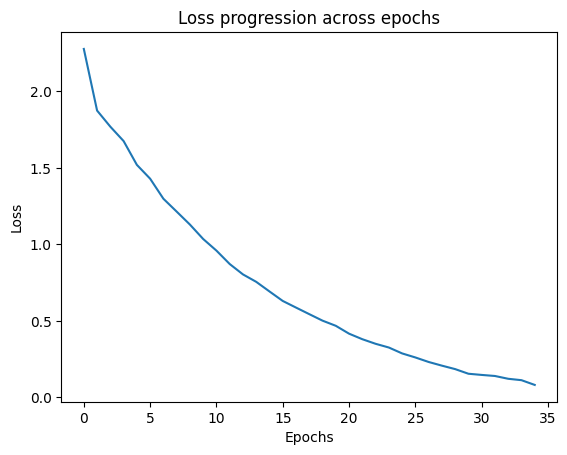

In [ ]:

plot_loss(fit_data)

# predict with the trained model
predict(
    model,
    test_dataloader = test_dataloader,
    device = DEVICE
)


Now, we add skip connections. Notice that sometimes the skip connection cannot be simply an identity function, since the dimensions will not match. Identify the condition when this is necessary. In that case, the shortcut function should be a convolution followed by BatchNorm.

**Question** Fill the code below and train the network!

### Evaluated!
**Question:** It looks like the model without the residual connections performs better (3-4%), but on a closer examination of the training curves the residual model achieves lower loss much faster and then plateaus. You might try to add a scheduler to boost the performance!

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# initialize the model
model = ResNet(block=NonResidualBlock, num_blocks=[2,2,2,2]).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# train the ResNet

fit_data =   fit(
        model,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 35,
        device = DEVICE
    )

Epoch 0: Loss=2.2094335799314537
Epoch 1: Loss=1.8802215201514108
Epoch 2: Loss=1.7531395834319445
Epoch 3: Loss=1.6093655970631813
Epoch 4: Loss=1.4871560602771992
Epoch 5: Loss=1.3139108224790923
Epoch 6: Loss=1.1811900868707774
Epoch 7: Loss=1.0654214681411276
Epoch 8: Loss=0.9703350188780804
Epoch 9: Loss=0.8791241974246745
Epoch 10: Loss=0.7925618120602199
Epoch 11: Loss=0.7111317807314347
Epoch 12: Loss=0.640635722753953
Epoch 13: Loss=0.5755980744653818
Epoch 14: Loss=0.5388877428307826
Epoch 15: Loss=0.48289782964453404
Epoch 16: Loss=0.43663967507226126
Epoch 17: Loss=0.3855391819866336
Epoch 18: Loss=0.35361607159887043
Epoch 19: Loss=0.30711858369866196
Epoch 20: Loss=0.27195931606146756
Epoch 21: Loss=0.2402078424181257
Epoch 22: Loss=0.21163137986951944
Epoch 23: Loss=0.18332262063512997
Epoch 24: Loss=0.16042711464117984
Epoch 25: Loss=0.13137824377235102
Epoch 26: Loss=0.13254634412575741
Epoch 27: Loss=0.11966942600449737
Epoch 28: Loss=0.08757047727704048
Epoch 29: Los

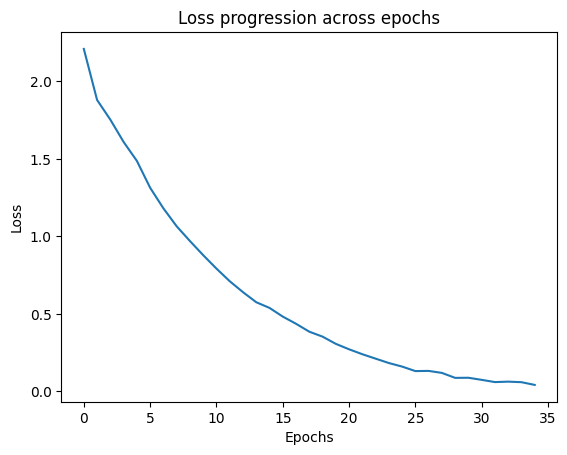

In [ ]:
plot_loss(fit_data)